# Rubin Calibration Flat Field Calibration Exposure Time Calculator - Tunable Laser

This notebook is used to determine the exposure time needed to complete the flat field calibrations for Rubin using the white light sources (i.e. LEDs).

A further description can be found at https://sitcomtn-049.lsst.io

In [36]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpolate
import scipy

from scipy.integrate import simps

In [306]:
plt.rc('font', size=14, family='serif')

## System Information

In [31]:
tput_dir = './baseline_tput_curves'
filter_info = {'u':[324,395.0] ,'g': [405,552,],'r':[552,691] ,'i':[691,818] ,'z':[818,921] , 'y4':[922,997] }

outer_diam = 9.27 # [m] 
inner_diam = 4.18 # [m]
area = np.pi * ((outer_diam-inner_diam)/2)**2 #[m2]

plate_scale = 0.2 # arcsec/pixel
total_number_of_pixels = 3.2e9 # 3.2 gigapixels
h = 6.626e-34 # m2 kg / s
c = 3e8 # m/s

## Requirement

Requirement TLS-REQ-0096 states we need an exitance from the screen of 3 milli-Jansky's per arcsec^2 (as measured on the detector)

In [4]:
TLS_REQ_0096 = 3e-3 # [mJ/arcsec2]
SNR_REQ = 1000

def required_exitance(wave_m):
    """
    [Jy/arcsec^2 * W/m2/Hz/Jy * c/lambda^2] = W/m2/um/arcsec^2
    1 Jy =  10-26 Watts m-2 Hz-1 
    """
    exitance_SI = TLS_REQ_0096 * 10**(-26.0) * (c/(wave_m)**2) * 1e-6 # W/m2/um/arcsec^2
    exitance = exitance_SI * area
    return exitance


In [5]:
def required_photon_rate(test_wave, test_filter):
    test_wave_m = test_wave * 1e-9 #nm to m
    filter_start, filter_stop = filter_info[test_filter]
    filter_bandpass = (filter_stop - filter_start) * 1e-9 * 1e6 # um  
    filter_central_wavelength_m = (filter_stop + filter_start)/2. * 1e-9 #nm to m
    
    photon_rate = required_exitance(test_wave_m) * (filter_bandpass * (plate_scale**2) )  / ((h*c)/ filter_central_wavelength_m)  # ph/s/pix
    
    return photon_rate, filter_bandpass, filter_central_wavelength_m, test_filter

In [6]:
def required_exp_time(photon_rate):
    t = (SNR_REQ**2)/photon_rate
    return t

### Laser Output

I took this file from Patrick's github. Not sure where it came from. https://github.com/patrickingraham/LSST_main_telescope_calibration_notebooks/blob/master/laser_throughput_calc/Flat%20Field%20Illumination%20Throughput%20White%20Light%20-%20Single%20Projector%20-%20no%20Fiber.ipynb

In [13]:
#In uJ
laser_df = pd.read_csv('/Users/pfagrelius/Research/Rubin/baseline_tput_curves/PGD151_NT242.txt',delim_whitespace=True)

In [291]:
#pulse rate  = 1000.0 pulses per second
laser_df['Power'] = laser_df.Avg * 1e-6 * 1000# W

Text(0.5, 1.0, 'Ekspla NT242')

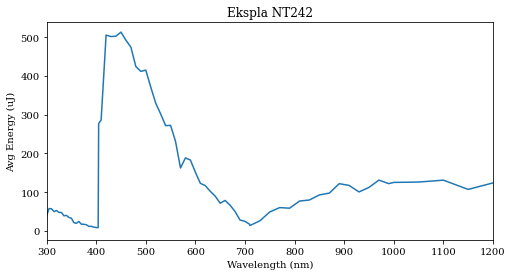

In [292]:
plt.figure(figsize=(8,4))
plt.plot(laser_df.Wavelength, laser_df.Avg)
plt.xlim(300, 1200)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Avg Energy (uJ)')
plt.title('Ekspla NT242')

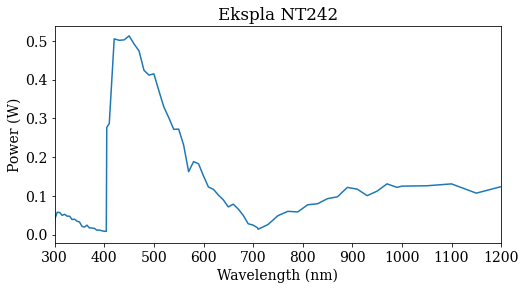

In [309]:
plt.figure(figsize=(8,4))
plt.plot(laser_df.Wavelength, laser_df.Power)
plt.xlim(300, 1200)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power (W)')
plt.title('Ekspla NT242')
plt.savefig('nt242_output.png')

## Exposure Time Calculator

### Throughput

#### Calibration System Throughput

In [21]:
# Fiber efficiency - assuming 15 meters length
# plots are in weird units (dB/km) - want to put that into transmission per meter.
# data from http://www.ceramoptec.de/products/fibers/optran-uv-wf.html

fiber_distance = 15 # meters
fiber_wave= np.array([300,350,400,500,600,700,800,900,950,1000,1100.0,1200.0]) # in nm
fiber_att_db_km0 = np.array([140, 70, 35, 15,8.5,  6,  5,  5,6.5, 3.5,   3,2]) # in db/km

# convert to transmission over the distance
fiber_att = (10**(-fiber_att_db_km0/1000*fiber_distance/10.0)) # transmission per m

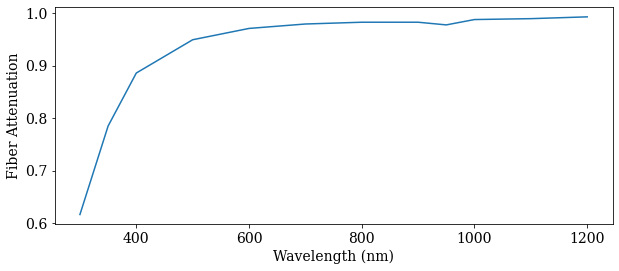

In [307]:
plt.figure(figsize=(10,4))
plt.plot(fiber_wave, fiber_att)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Fiber Attenuation")
plt.savefig('fiber_att.png')

In [24]:
fiber_coupling_tput = 0.5 # guess from Patrick, not sure exactly what this is

In [290]:
system_tput = 0.01/100. # from Ming/Zemax calculation at 660nm
total_tput = fiber_att * fiber_coupling_tput * system_tput

In [155]:
# Remove filter dependence in model at 660 nm
r_filter = pd.read_csv(os.path.join(tput_dir, 'ideal_r.dat'),skiprows=4, delim_whitespace=True, names=['wave','transmission'])
r_filter_660 = float(r_filter[r_filter.wave == 660.]['transmission'])
filterless_tput = total_tput/r_filter_660

In [156]:
calib_tput = scipy.interpolate.griddata(fiber_wave, filterless_tput, laser_df.Wavelength, method='linear')
calib_tput.shape

(123,)

#### Filter Transmission

In [294]:
filter_bandpass = {}
filter_transmission = {}
for filter_name, lims in filter_info.items():
    filter_trans = pd.read_csv(os.path.join(tput_dir,'ideal_{}.dat'.format(filter_name)), delim_whitespace=True, skiprows=2,names=['Wavelength','Throughput'])
    
    # Smooth to find edges of filter - No longer doing this. Changes exp time by 0.1 seconds.
    min_trans = 0.01
    smoothed_filter_profile = np.convolve(filter_trans.Throughput, [0,1,1,1,0], mode='same')
    
    idx = np.where((smoothed_filter_profile > min_trans)&(filter_trans.Wavelength < filter_info[filter_name][1]+50))
    
    filter_bandpass_ = filter_trans.iloc[idx[0]]['Wavelength']
    
    filter_transmission_ = scipy.interpolate.griddata(filter_trans.Wavelength, filter_trans.Throughput, filter_bandpass_, method='linear')
    filter_bandpass[filter_name] = filter_bandpass_
    filter_transmission[filter_name] = filter_transmission_

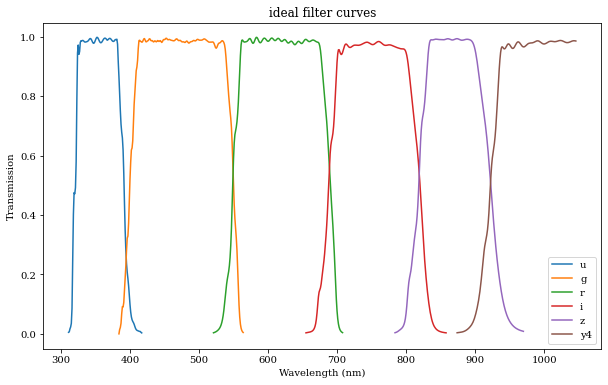

In [295]:
plt.figure(figsize=(10,6))
for filter_name, lims in filter_info.items():
    plt.plot(filter_bandpass[filter_name], filter_transmission[filter_name],label=filter_name)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmission')
plt.title('ideal filter curves')
plt.legend()
plt.savefig('ideal_filters.png')

#### Camera Throughput

In [296]:
detector_efficiency = {}
# Detector efficiency
det_filename = os.path.join(tput_dir, 'detector_e2vPrototype.dat')
det_tput = pd.read_csv(det_filename, delim_whitespace=True, skiprows=5, names=['Wavelength','Throughput']) # wavelength [nm], Transmission

for filter_name, fb in filter_bandpass.items():
    #interpolate to filter_bandpass
    detector_eff = scipy.interpolate.griddata(det_tput.Wavelength, det_tput.Throughput, fb, method='linear')
    detector_efficiency[filter_name] = detector_eff

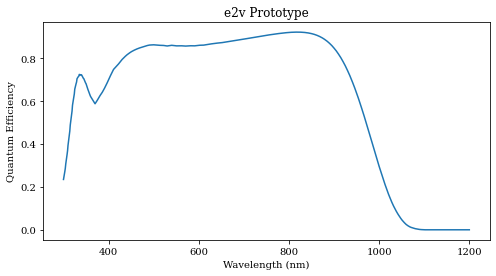

In [297]:
plt.figure(figsize=(8,4))
plt.plot(det_tput.Wavelength, det_tput.Throughput)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Quantum Efficiency')
plt.title('e2v Prototype')
plt.savefig('det_tput.png')

In [310]:
def get_integrated_count(wave_from_led, flux_from_led, filter_name): 
    try:

        photons_from_led = flux_from_led / (h*c/(wave_from_led*1e-9)) #convert W/nm to ph/sec/nm

        photons_on_focal_plane = photons_from_led * calib_tput #multiply by throughput of calib optical system
        #print(photons_on_focal_plane.shape)
        ph = scipy.interpolate.interp1d(wave_from_led, photons_on_focal_plane)

        #put everything on the same grid (source, filter, detector)
        photons_on_filter = scipy.interpolate.griddata(wave_from_led, photons_on_focal_plane/total_number_of_pixels, filter_bandpass[filter_name], method='linear')
        
        #multiply by transmission of filters and detector
        count_rate = photons_on_filter * filter_transmission[filter_name] * detector_efficiency[filter_name] # ph/pix/s/nm     

        #divide by number of pixels to get ph/pix/sec/nm
        counts_per_pixel = count_rate

        integrated_ph_rate = simps(counts_per_pixel[~np.isnan(counts_per_pixel)], filter_bandpass[filter_name][~np.isnan(counts_per_pixel)])

        return counts_per_pixel, filter_bandpass[filter_name], integrated_ph_rate
    except:
        pass

## Results

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


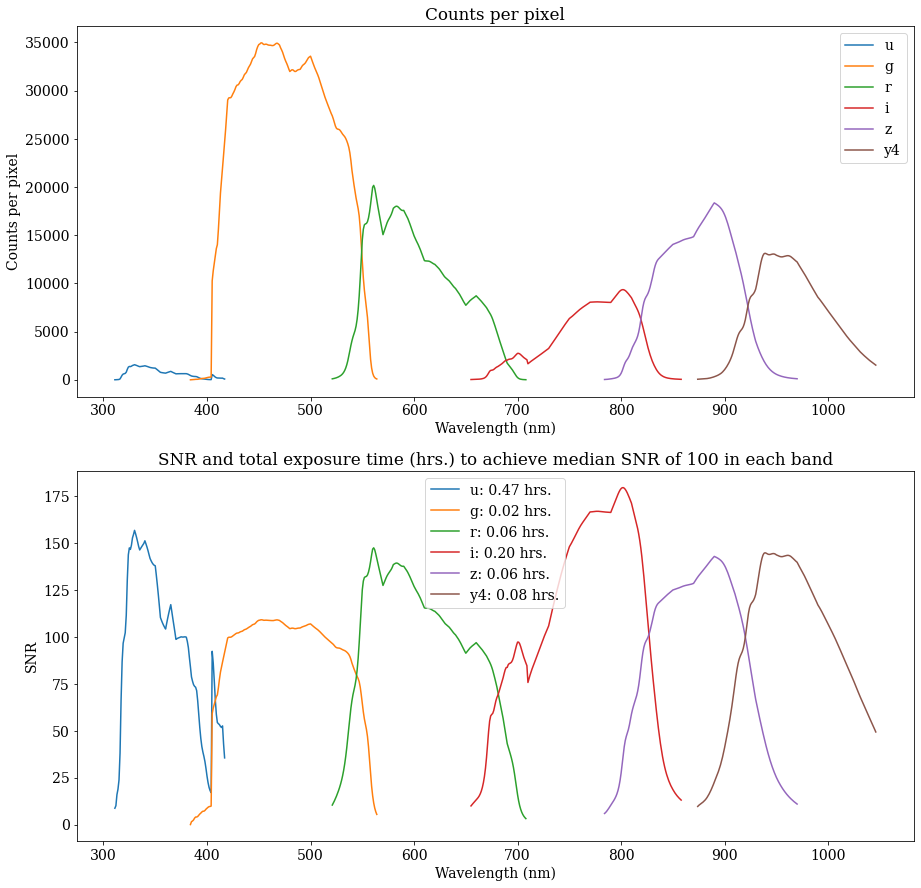

In [329]:
med_snr = 100
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))
for filter_, lims in filter_info.items():
    counts_per_pix, filter_wave, int_ph_rate = get_integrated_count(laser_df.Wavelength, laser_df.Power, filter_)
    time_per_wave = (med_snr**2)/counts_per_pix
    time_for_median = (med_snr**2)/np.median(counts_per_pix)*len(filter_wave) #sec
    snr_for_wave = med_snr * np.sqrt(counts_per_pix/np.median(counts_per_pix))
    ax1.plot(filter_wave, counts_per_pix, label=filter_)
    ax2.plot(filter_wave, snr_for_wave, label='{}: {:.2f} hrs.'.format(filter_, time_for_median/3600.))
    
ax1.legend()
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Counts per pixel')
ax1.set_title('Counts per pixel')

ax2.legend()
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('SNR')
ax2.set_title('SNR and total exposure time (hrs.) to achieve median SNR of 100 in each band')

plt.savefig('laser_snr_plots.png')